In [ ]:
import torch
import torchvision
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# используем предобученную keypointrcnn_resnet50_fpn сеть
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

# создаем список опорных точек
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']


Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


  0%|          | 0.00/226M [00:00<?, ?B/s]

In [ ]:
from torchvision import transforms as T

# загружаем изображение с opencv 
img_path ="running_girl.jpg"
img = cv2.imread(img_path)

# трансформируем изображение
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

#прогоняем изображение через модель, получаем список
output = model([img_tensor])[0]


In [ ]:
import matplotlib.pyplot as plt

def draw_keypoints_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    # создаем спектр цветов
    cmap = plt.get_cmap('rainbow')
    # создаем копию изображений
    img_copy = img.copy()
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
      # проверяем степень уверенности детектора
      if confs[person_id]>conf_threshold:
        # собираем опорные точки конкретного человека
        keypoints = all_keypoints[person_id, ...]
        # собираем скоры для опорных точек
        scores = all_scores[person_id, ...]
        #итерируем по каждому скору
        for kp in range(len(scores)):
            # проверяем степень уверенности детектора опорной точки
            if scores[kp]>keypoint_threshold:
                # конвертируем массив опорных точек в список целых чисел
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                # выбираем цвет
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # рисуем кружок радиуса 5 вокруг точки
                cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

In [ ]:
keypoints_img = draw_keypoints_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"], keypoint_threshold=2)

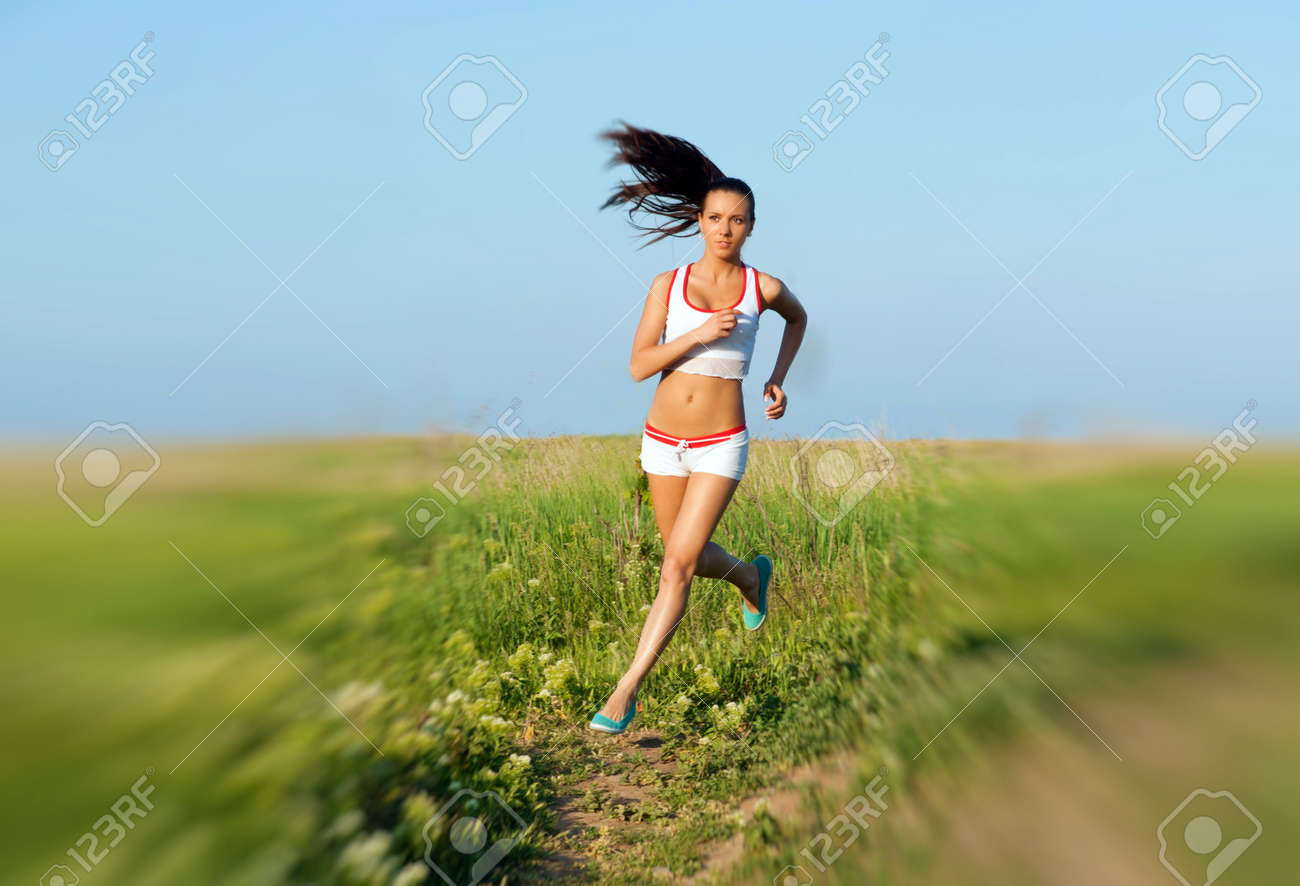

In [ ]:
cv2_imshow(img)

In [ ]:
cv2_imshow(keypoints_img)

In [ ]:
def get_limbs_from_keypoints(keypoints):
  limbs = [       
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
  return limbs

limbs = get_limbs_from_keypoints(keypoints)

In [1]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    
    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    if len(output["keypoints"])>0:
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      for person_id in range(len(all_keypoints)):
          if confs[person_id]>conf_threshold:
            keypoints = all_keypoints[person_id, ...]

    
            for limb_id in range(len(limbs)):
              # выберите первоначальную точку конечности 1
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              # выберите первоначальную точку конечности 2
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
              # рассматривайте оценку уверенности конечностей как минимальную оценку ключевой точки среди двух оценок ключевых точек
              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              # проверяем, если скор конечностей превосходит порог
              if limb_score> keypoint_threshold:
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # рисуем линию шириной 5
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 5)

    return img_copy

In [ ]:
skeletal_img = draw_skeleton_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

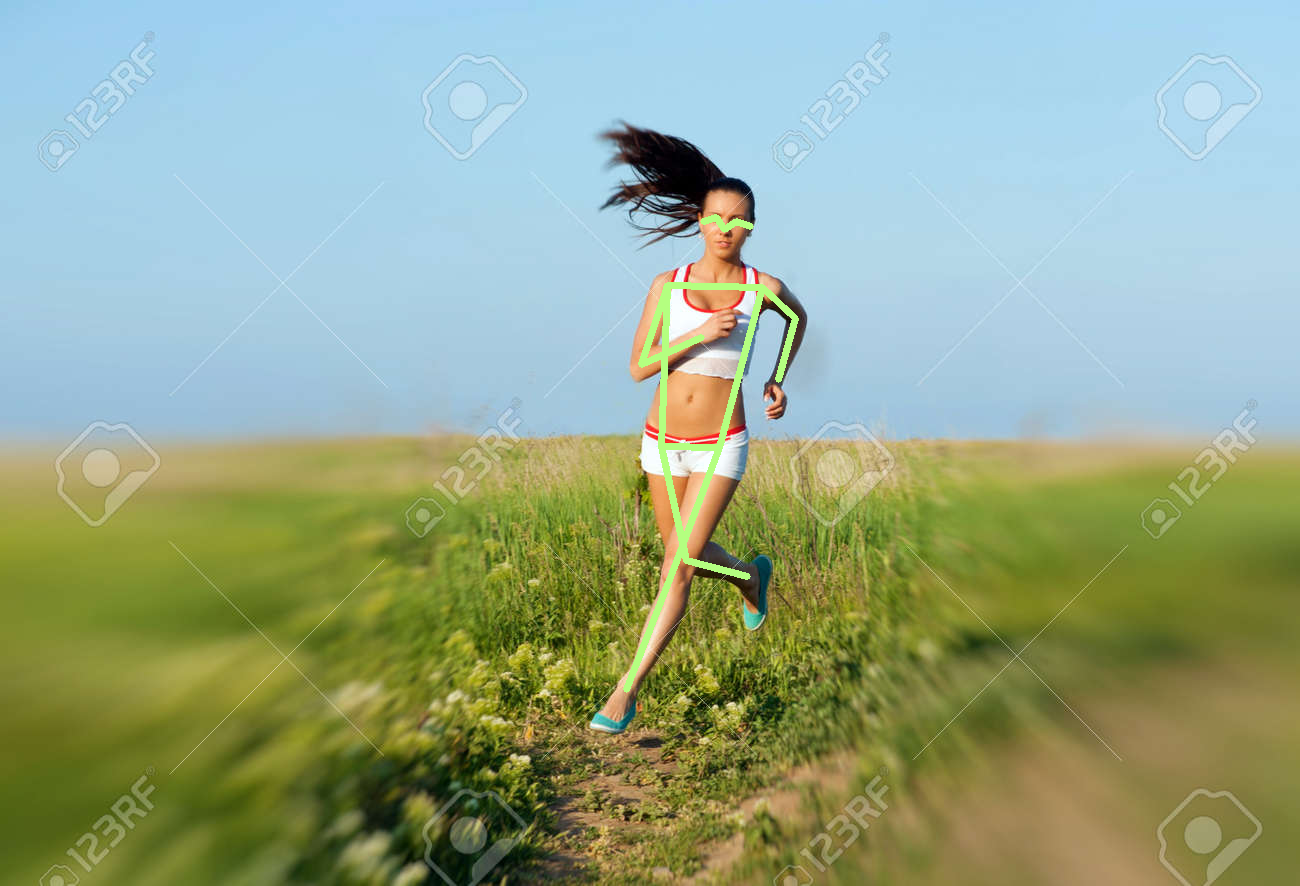

In [ ]:
cv2_imshow(skeletal_img)